In [1]:
import pandas as pd

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 25)

# Load dataset
df1 = pd.read_csv("train.csv")
df2 = pd.read_csv("test.csv")

In [2]:
# Enforce datatypes and fix UNIX time
def process_dataset(df):
    # Format dates
    df["transDate"] = pd.to_datetime(df["transDate"])
    df["dateOfBirth"] = pd.to_datetime(df["dateOfBirth"], format="%Y-%m-%d")
    df["unixTime"] = pd.to_datetime(df["unixTime"], unit="s")

    # Format categories
    df["business"] = df["business"].astype("category")
    df["category"] = df["category"].astype("category")
    df["gender"] = df["gender"].astype("category")
    df["city"] = df["city"].astype("category")
    df["state"] = df["state"].astype("category")
    df["job"] = df["job"].astype("category")

    # Format strings
    df["creditCardNum"] = df["creditCardNum"].astype(str)
    df["firstName"] = df["firstName"].astype(str)
    df["lastName"] = df["lastName"].astype(str)
    df["street"] = df["street"].astype(str)
    df["zip"] = df["zip"].astype(str)
    df["transNum"] = df["transNum"].astype(str)

    # Format bool
    df["isFraud"] = df["isFraud"].astype(bool)

    # Fix UNIX time
    df["transDate"] = df["unixTime"] + pd.DateOffset(years=7)
    df.drop(columns=["unixTime"], inplace=True)


process_dataset(df1)
process_dataset(df2)

In [3]:
# Separate redundant cardholder data to a separate table

cardholder_cols = [
    "creditCardNum",
    "firstName",
    "lastName",
    "gender",
    "street",
    "city",
    "state",
    "zip",
    "latitude",
    "longitude",
    "cityPop",
    "job",
    "dateOfBirth",
]

cardholders = df1[cardholder_cols].drop_duplicates().reset_index(drop=True)
cardholders.sort_values(by="creditCardNum", inplace=True)
cardholders.set_index("creditCardNum", inplace=True)
cardholders["lastTransaction"] = ""
cardholders["meanPurchasePrice"] = 0.0
cardholders["numberOfTransactions"] = 0
cardholders["sumSquareDiffs"] = 0.0
cardholders["historyOfFraud"] = False

cardholders.to_csv("cardholders.csv", index=False)

to_drop = [
    "firstName",
    "lastName",
    "gender",
    "street",
    "city",
    "state",
    "zip",
    "latitude",
    "longitude",
    "cityPop",
    "job",
    "dateOfBirth",
]

transactions = df1.copy()
transactions.set_index("transNum", inplace=True)
transactions.drop(columns=to_drop, inplace=True)

In [4]:
import csv
import os

from vincenty import vincenty_inverse


def distance_from_home(trans_row, cardholder_row):
    coords_home = (cardholder_row["longitude"], cardholder_row["latitude"])
    coords_purchase = (trans_row["merchLongitude"], trans_row["merchLatitude"])

    return vincenty_inverse(coords_home, coords_purchase).km


def distance_from_last(last, current):
    coords_last = (last["merchLongitude"], last["merchLatitude"])
    coords_current = (current["merchLongitude"], current["merchLatitude"])

    return vincenty_inverse(coords_last, coords_current).km


def time_since_last(last, current):
    return (current["transDate"] - last["transDate"]).seconds


file_path = "new_col_data.csv"

if os.path.exists(file_path):
    os.remove(file_path)
file = open(file_path, "a")
handler = csv.writer(file)
handler.writerow(
    ["transNum", "distanceFromHome", "distanceFromLast", "secondsSinceLast", "priceSD"]
)


for index, transaction in transactions.iterrows():
    credit_card_num = transaction["creditCardNum"]
    if credit_card_num in cardholders.index:
        cardholder = cardholders.loc[credit_card_num]
    else:
        raise Exception("Cardholder not found")

    if cardholder["numberOfTransactions"] == 0:
        cardholder["meanPurchasePrice"] = transaction["amount"]
        cardholder["numberOfTransactions"] = 1
        cardholder["sumSquareDiffs"] = 0.0
    else:
        cardholder["meanPurchasePrice"] = (
            cardholder["meanPurchasePrice"] * cardholder["numberOfTransactions"]
            + transaction["amount"]
        ) / (cardholder["numberOfTransactions"] + 1)
        cardholder["numberOfTransactions"] += 1
        cardholder["sumSquareDiffs"] += (
            transaction["amount"] - cardholder["meanPurchasePrice"]
        ) ** 2

    priceSD = (cardholder["sumSquareDiffs"] / cardholder["numberOfTransactions"]) ** 0.5

    distanceFromHome = distance_from_home(transaction, cardholder)

    if cardholder["lastTransaction"] != "":
        lastTransaction = transactions.loc[cardholder["lastTransaction"]]
        distanceFromLast = distance_from_last(lastTransaction, transaction)
        secondsSinceLast = time_since_last(lastTransaction, transaction)
    else:
        distanceFromLast = -1
        secondsSinceLast = -1

    handler.writerow(
        [index, distanceFromHome, distanceFromLast, secondsSinceLast, priceSD]
    )

    cardholder["lastTransaction"] = index
    if not transaction["isFraud"]:
        cardholders.loc[credit_card_num] = cardholder
    else:
        cardholder = cardholders.loc[credit_card_num]
        cardholder["historyOfFraud"] = True
        cardholders.loc[credit_card_num] = cardholder

file.close()

/var/folders/dy/nrpbxz756vv3_l8mp02k87k80000gn/T/ipykernel_55524/3914039861.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cardholder["meanPurchasePrice"] = transaction["amount"]
/var/folders/dy/nrpbxz756vv3_l8mp02k87k80000gn/T/ipykernel_55524/3914039861.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cardholder["numberOfTransactions"] = 1
/var/folders/dy/nrpbxz756vv3_l8mp02k87k80000gn/T/ipykernel_55524/3914039861.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [5]:
print(transactions)
print(cardholders)

                                           transDate        creditCardNum  \
transNum                                                                    
3fc1791ff1db94ce9540262d7eb973e4 2019-01-01 04:28:00     4119762878330980   
edbf65b8606b53fc48168c2daa5933e5 2019-01-01 04:28:15       36078114201167   
2fcbde131cff833751dde53da54da6da 2019-01-01 04:29:14     4449530933957320   
bcae564f9a1a299dfbd1efd917499968 2019-01-01 04:29:18     4302475216404890   
5e42e35c255edb55a192b3f1f0600936 2019-01-01 04:32:09      377234009633447   
...                                              ...                  ...   
16cfc30968a4ffc36f44a8fa4d98224f 2019-12-15 13:48:38  4958589671582720000   
9c68a7b61b6d9a1afd3db343f6943e0e 2019-12-15 13:48:53     2576709887791550   
e715a05b1aab3b771d6c22a0ef0e6fcd 2019-12-15 13:49:05     6011679934075340   
df05203f1050a2621bd8c4e41a3e4d8b 2019-12-15 13:49:20  4102003771126570000   
e54fed36ad03af47c786c3b56fd1c326 2019-12-15 13:49:26     4629451965224800   

In [ ]:
import plotly.express as px

fig = px.scatter_geo(
    transactions[transactions["isFraud"] == True],
    lat="merchLatitude",
    lon="merchLongitude",
    color="isFraud",
    scope="usa",
)
fig.update_layout(title="Fraudulent Transaction Map", title_x=0.5)
fig.show(renderer="iframe")

In [9]:
grouped_transactions = transactions.groupby("category")

total_transactions = grouped_transactions.size()
fraud_transactions = grouped_transactions["isFraud"].sum()

fraud_rate = (fraud_transactions / total_transactions) * 100
fraud_rate.sort_values(ascending=False)

/var/folders/dy/nrpbxz756vv3_l8mp02k87k80000gn/T/ipykernel_55524/2353051942.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_transactions = transactions.groupby("category")


category
shopping_net      2.310110
misc_net          1.806350
grocery_pos       1.767254
shopping_pos      1.047730
gas_transport     0.578761
misc_pos          0.418932
grocery_net       0.350653
entertainment     0.325758
travel            0.300725
personal_care     0.298039
kids_pets         0.206237
health_fitness    0.192791
home              0.190268
food_dining       0.154943
dtype: float64

In [7]:
grouped_transactions = df1.groupby("business")

total_transactions = grouped_transactions.size()
fraud_transactions = grouped_transactions["isFraud"].sum()

fraud_rate = (fraud_transactions / total_transactions) * 100
fraud_rate.sort_values(ascending=False)

/var/folders/dy/nrpbxz756vv3_l8mp02k87k80000gn/T/ipykernel_55524/2665670620.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_transactions = df1.groupby("business")


business
fraud_Rau and Sons                     4.324324
fraud_Boyer-Reichert                   4.280156
fraud_Towne, Greenholt and Koepp       3.971119
fraud_Rempel Inc                       3.859649
fraud_Schmeler, Bashirian and Price    3.754266
                                         ...   
fraud_Fritsch and Sons                 0.000000
fraud_Pacocha-Weissnat                 0.000000
fraud_Funk Group                       0.000000
fraud_Gaylord-Powlowski                0.000000
fraud_Donnelly LLC                     0.000000
Length: 693, dtype: float64

In [14]:
# Setup final dataset

# combine all data
computed_cols = pd.read_csv("new_col_data.csv")
computed_cols.set_index("transNum", inplace=True)
df = transactions.join(computed_cols, on="transNum")
df = df.join(cardholders, on="creditCardNum")

# drop irrelevant columns
irrelevant_cols = [
    "transDate",
    "creditCardNum",
    "firstName",
    "lastName",
    "street",
    "zip",
    "latitude",
    "longitude",
    "merchLatitude",
    "merchLongitude",
    "lastTransaction",
    "meanPurchasePrice",
    "numberOfTransactions",
    "sumSquareDiffs",
]
df.drop(columns=irrelevant_cols, inplace=True)

# compute age
df["age"] = pd.to_datetime("today") - df["dateOfBirth"]
df["age"] = df["age"].dt.days / 365
df["age"] = df["age"].astype(int)
df.drop(columns=["dateOfBirth"], inplace=True)

# encode gender
gender_mapping = {"M": 1, "F": 0}
df["gender_male"] = df["gender"].map(gender_mapping)
df.drop(columns=["gender"], inplace=True)

# encode business
grouped_transactions = df1.groupby("business")
total_transactions = grouped_transactions.size()
fraud_transactions = grouped_transactions["isFraud"].sum()
fraud_rate = (fraud_transactions / total_transactions) * 100
result_dict = fraud_rate.to_dict()

df["business_fraudrate"] = df["business"].map(result_dict)
df.drop(columns=["business"], inplace=True)

# encode category
grouped_transactions = df1.groupby("category")
total_transactions = grouped_transactions.size()
fraud_transactions = grouped_transactions["isFraud"].sum()
fraud_rate = (fraud_transactions / total_transactions) * 100
result_dict = fraud_rate.to_dict()

df["category_fraudrate"] = df["category"].map(result_dict)
df.drop(columns=["category"], inplace=True)

# encode city
grouped_transactions = df1.groupby("city")
total_transactions = grouped_transactions.size()
fraud_transactions = grouped_transactions["isFraud"].sum()
fraud_rate = (fraud_transactions / total_transactions) * 100
result_dict = fraud_rate.to_dict()

df["city_fraudrate"] = df["city"].map(result_dict)
df.drop(columns=["city"], inplace=True)

# encode state
grouped_transactions = df1.groupby("state")
total_transactions = grouped_transactions.size()
fraud_transactions = grouped_transactions["isFraud"].sum()
fraud_rate = (fraud_transactions / total_transactions) * 100
result_dict = fraud_rate.to_dict()

df["state_fraudrate"] = df["state"].map(result_dict)
df.drop(columns=["state"], inplace=True)

# encode job
grouped_transactions = df1.groupby("job")
total_transactions = grouped_transactions.size()
fraud_transactions = grouped_transactions["isFraud"].sum()
fraud_rate = (fraud_transactions / total_transactions) * 100
result_dict = fraud_rate.to_dict()

df["job_fraudrate"] = df["job"].map(result_dict)
df.drop(columns=["job"], inplace=True)

/var/folders/dy/nrpbxz756vv3_l8mp02k87k80000gn/T/ipykernel_55524/537968090.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_transactions = df1.groupby("business")
/var/folders/dy/nrpbxz756vv3_l8mp02k87k80000gn/T/ipykernel_55524/537968090.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_transactions = df1.groupby("category")
/var/folders/dy/nrpbxz756vv3_l8mp02k87k80000gn/T/ipykernel_55524/537968090.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to

In [15]:
df

,amount,isFraud,distanceFromHome,distanceFromLast,secondsSinceLast,priceSD,cityPop,historyOfFraud,age,gender_male,business_fraudrate,category_fraudrate,city_fraudrate,state_fraudrate,job_fraudrate
transNum,,,,,,,,,,,,,,,
3fc1791ff1db94ce9540262d7eb973e4,4.10,False,47.229861,-1.000000,-1,0.000000,6713,False,78,0,2.247191,1.806350,0.000000,0.806319,0.000000
edbf65b8606b53fc48168c2daa5933e5,2.67,False,27.264981,-1.000000,-1,0.000000,798,False,97,1,0.829876,2.310110,0.000000,1.080020,1.284404
2fcbde131cff833751dde53da54da6da,22.88,False,116.068684,-1.000000,-1,0.000000,337,False,69,0,0.000000,0.418932,0.000000,0.419580,0.000000
bcae564f9a1a299dfbd1efd917499968,9.59,False,80.518979,-1.000000,-1,0.000000,3032,False,59,1,0.000000,0.418932,0.000000,0.325291,0.000000
5e42e35c255edb55a192b3f1f0600936,129.06,False,65.543964,-1.000000,-1,0.000000,1925,True,58,0,2.719033,1.767254,4.577465,0.618499,1.186131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16cfc30968a4ffc36f44a8fa4d98224f,72.97,False,40.897276,82.397940,13171,80.433603,43102,False,73,1,0.000000,0.206237,0.000000,0.493705,0.000000
9c68a7b61b6d9a1afd3db343f6943e0e,7.50,False,29.410519,103.695127,8198,64.068313,1241364,False,64,1,0.806452,0.300725,0.000000,0.419580,0.000000
e715a05b1aab3b771d6c22a0ef0e6fcd,46.18,False,89.146589,40.983171,3723,82.925814,100,True,50,0,0.387597,0.298039,5.045872,0.876190,5.045872


<Axes: title={'center': 'state_fraudrate'}, xlabel='isFraud'>

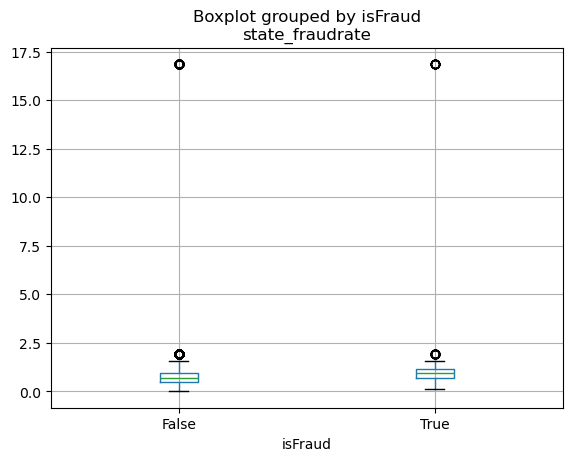

In [27]:
df.boxplot(column="state_fraudrate", by="isFraud")

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
data = df.copy()
X = data.drop(columns=["isFraud"])
y = data["isFraud"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

# Standardize features
ss_train = StandardScaler()
X_train = ss_train.fit_transform(X_train)

ss_test = StandardScaler()
X_test = ss_test.fit_transform(X_test)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machines": LinearSVC(),
    "Decision Trees": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbor": KNeighborsClassifier(),
}

accuracy, precision, recall = {}, {}, {}

for key in models.keys():

    # Fit the classifier
    models[key].fit(X_train, y_train)

    # Make predictions
    predictions = models[key].predict(X_test)

    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)


df_model = pd.DataFrame(
    index=models.keys(), columns=["Accuracy", "Precision", "Recall"]
)
df_model["Accuracy"] = accuracy.values()
df_model["Precision"] = precision.values()
df_model["Recall"] = recall.values()

df_model

/Users/michael/.pyenv/versions/miniforge3-4.10.3-10/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/michael/.pyenv/versions/miniforge3-4.10.3-10/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/michael/.pyenv/versions/miniforge3-4.10.3-10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Precision,Recall
Logistic Regression,0.994918,0.418994,0.867052
Support Vector Machines,0.995204,0.460894,0.868421
Decision Trees,0.996788,0.798883,0.794444
Random Forest,0.997470,0.715084,0.951673
Naive Bayes,0.992124,0.000000,0.000000
K-Nearest Neighbor,0.996282,0.606145,0.885714


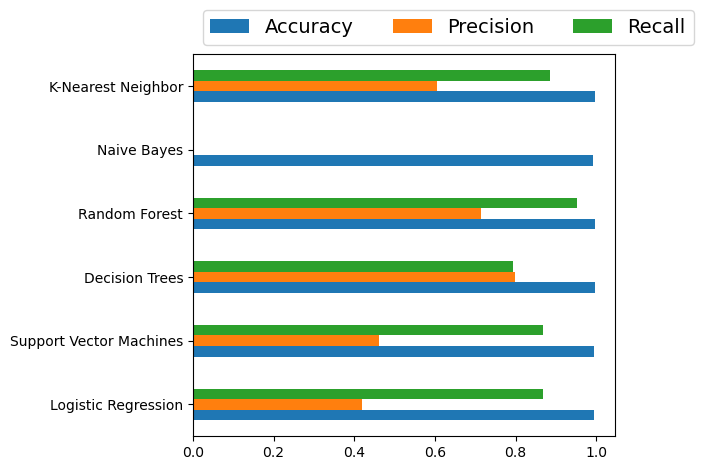

In [18]:
import matplotlib.pyplot as plt

ax = df_model.plot.barh()
ax.legend(
    ncol=len(models.keys()), bbox_to_anchor=(0, 1), loc="lower left", prop={"size": 14}
)
plt.tight_layout()